# Preprocessing for numerical features

In this notebook we will introduce these new aspects when working with numerical data:

* an example of preprocessing, namely **scaling numerical variables**;
* using a scikit-learn **pipeline** to chain preprocessing and model trianing;
* assessing the generalization performance of our model via **cross-validation** instead of a single train-test split.

## Data Preparation

We start as usual by importing the required libraries and loading the data set.

In [2]:
import pandas as pd
from sklearn import set_config
set_config(display='diagram')

df = pd.read_csv("data/adult-census.csv")
df.sample(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
21697,74,Private,211075,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,30,United-States,<=50K
24696,20,Private,216436,Bachelors,13,Never-married,Sales,Other-relative,Black,Female,0,0,30,United-States,<=50K
18517,60,Private,207665,HS-grad,9,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,40,United-States,>50K


We then drop the features, that don't contain valuable info.

In [3]:
# drop not needed columns
df = df.drop(columns=['fnlwgt', 'education'])

# split target and features
target = df['class']
# we are considering only numerical features
data = df.select_dtypes(include='number')

Now, we can start with preparing our model.  
The first step is to divide our data into a training and test sets:

In [5]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=.25,
                                                                   random_state=23)

## Model Fitting with Preprocessing

A range of preprocessing algorithms in scikit-learn allow us to transform the input data before training a model. In our case, we will standardize the data and then train a new logistic model on that new version of the dataset.

Let's start by printing some statistics about the training data

In [6]:
data_train.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,36631.000000,36631.000000,36631.000000,36631.000000,36631.000000
mean,38.689525,10.083645,1115.031640,84.717753,40.414976
std,13.735819,2.572581,7611.916806,397.034139,12.443421
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


From the above table, we can see the the data set's features span across different ranges. Some algorithms make some assumptions regarding the feature distribution and usually normalizing features will be helpful to address these assumptions.

The two main reasons why we should scale the training data:

1. Models that rely on the distance between a pair of samples, for instance k-neares neighbors, should be trained on normalized features to make each feature contribute approximately equally to the distance computations.
2. Many models such as logistic regression use a numerical solver (based on gradient descent) to find their optimal parameters. This solver converges faster when the features are scaled.

Whether or not a machine learning model reequires scaling the features depends on the model family. Linear models such as logistic regression generally benefit from scaling the features while other models such as decision trees do not need such preprocessing (but will not suffer from it).

We will show how to apply such normalization using a scikit-learn transformer called `StandardScaler`. this transformer shifts and scales each feature individually so that they all have a 0-mean and a unit standard deviation.

We will investigate different steps used in scikit-learn to achieve such a transformation of the data.

First, one needs to call the method `fit` in order to learn the scaling from the data.

In [7]:
from sklearn.preprocessing import StandardScaler

# the standard scaler is usually called scaler
scaler = StandardScaler()
# We fit only the training data (without target)
scaler.fit(data_train)

StandardScaler()

The fit method for transformers is similar to the `fit` method for predictors. The main difference is that the former has a single argument (the data matrix), whereas the latter has two arguments (the data matrix and the target).

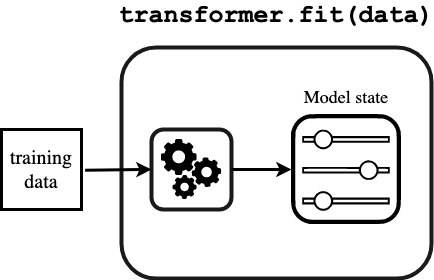

In this case, the algorith needs to compute the mean and standard deviation for each feature and store them into some Numpy arrays. Here, these statistics are the model states.

We can inspect the computed means and standard deviation:

In [8]:
scaler.mean_

array([  38.68952527,   10.083645  , 1115.03163987,   84.71775272,
         40.41497639])

In [9]:
scaler.scale_

array([1.37356316e+01, 2.57254607e+00, 7.61181291e+03, 3.97028720e+02,
       1.24432516e+01])

<div class="alert alert-block alert-info">
<b>scikit-learn convention:</b> <br>
     If an attribute is learned from the data, its name ends with an underscore (i.e. _), as in `mean_` and `scale_` for the `StandardScaler`.</div>
     
Scaling the data is applied to each feature individually. For each feature, we subtract its mean and divide by its standard deviation.

Once we have called the `fit` method, we can perform data transformation by calling the method `transform`.